In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, PIL, pathlib
import numpy as np
import pandas as pd
import warnings 
from tensorflow import keras

In [51]:
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 减少TensorFlow日志输出
# 0(deflaut):输出所有日志信息(INFO, WARNIING, ERROR, FATAL)  1:过滤掉INFO  2:过滤掉INFO,WARNING  3:只剩FATAL

In [3]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 1 # 灰度图
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
BATCH_SIZE = 32
NO_EPOCHS = 50
PATIENCE = 5
VERBOSE = 1

In [4]:
data_df = pd.read_csv('data/chinese_mnist.csv')

data_df.sample(100).head()

,suite_id,sample_id,code,value,character
14555,59,5,9,8,八
8876,88,6,3,2,二
7427,47,7,2,1,一
12895,9,5,7,6,六
7876,88,6,2,1,一


In [5]:
# 检查缺失值
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False) # *100:转换为百分比
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(data_df)

,Total,Percent
suite_id,0,0.0
sample_id,0,0.0
code,0,0.0
value,0,0.0
character,0,0.0


In [6]:
IMAGE_PATH = 'data/pictures/'
image_files = list(os.listdir(IMAGE_PATH))
print('数据总量: {}'.format(len(image_files)))

数据总量: 15000


In [7]:
def create_file_name(x):
    file_name = f'input_{x[0]}_{x[1]}_{x[2]}.jpg' # x[0/1/2]代表这一行的0/1/2列
    return file_name

data_df['file'] = data_df.apply(create_file_name, axis=1) # apply: 将函数应用到DataFrame中的一行/列 当axis=1时 create_file_name的输入x代表DataFrame中的一行

file_names = list(data_df['file'])
print('匹配到的数据总量: {}'.format(len(set(file_names).intersection(image_files)))) # 计算交集 验证是否所有文件都存在

匹配到的数据总量: 15000


In [8]:
# 读取图像尺寸
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name) # skimage.io.imread():scikit-image库中用于读取图像的函数
    return list(image.shape)

In [9]:
import skimage
import skimage.io
import skimage.transform
m = np.stack(data_df['file'].apply(read_image_sizes)) # apply返回的是一个Series np.stack():将这些列表沿着一个新的轴堆叠起来

df = pd.DataFrame(m, columns=['w', 'h'])
data_df = pd.concat([data_df, df], axis=1, sort=False)
data_df.head()

,suite_id,sample_id,code,value,character,file,w,h
0,1,1,10,9,九,input_1_1_10.jpg,64,64
1,1,10,10,9,九,input_1_10_10.jpg,64,64
2,1,2,10,9,九,input_1_2_10.jpg,64,64
3,1,3,10,9,九,input_1_3_10.jpg,64,64
4,1,4,10,9,九,input_1_4_10.jpg,64,64


In [10]:
from sklearn.model_selection import train_test_split

# 划分训练集、验证集和测试集
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_df['code'].values)
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=train_df['code'].values)

In [11]:
print('Training set rows: {}'.format(train_df.shape[0]))
print('Test     set rows: {}'.format(test_df.shape[0]))
print('Val      set rows: {}'.format(val_df.shape[0]))

Training set rows: 9600
Test     set rows: 3000
Val      set rows: 2400


In [12]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name) # 读取图像
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT, 1), mode='reflect') # 调整大小 param1:要调整大小的原始图像数组 param2:目标大小 param3:指定如何处理图像边界外的像素
    return image[:, :, :] # 等价于image

In [13]:
def categories_encoder(dataset, var='character'): # 
    X = np.stack(dataset['file'].apply(read_image)) # 创建特征数组X
    y = pd.get_dummies(dataset[var], drop_first=False) # 集中获取名为'var'的列 pd.get_dummies(..., drop_first=False)转为独热编码
    return X, y

In [14]:
train_df.shape

(9600, 8)

In [15]:
X_train, y_train = categories_encoder(train_df)
X_val,   y_val   = categories_encoder(val_df)
X_test,  y_test  = categories_encoder(test_df)

In [16]:
train_df.shape

(9600, 8)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=[64, 64, 1]),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),

    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,495 (87.87 KB)

 Trainable params: 22,495 (87.87 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
y_train.shape

(9600, 15)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS)) # 学习率衰减 x+NO_EPOCHS可减缓衰减速度

earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)

checkpointer = ModelCheckpoint('best_model.weights.h5', # 若save_weights_only=True, 则保存时要用.weight.h5
                               monitor='val_accuracy',
                               verbose=VERBOSE,
                               save_best_only=True,
                               save_weights_only=True)

In [21]:
train_model = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=NO_EPOCHS,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/50
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2849 - loss: 2.2059
Epoch 1: val_accuracy improved from None to 0.63583, saving model to best_model.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.4365 - loss: 1.8025 - val_accuracy: 0.6358 - val_loss: 1.2258 - learning_rate: 6.0501e-04
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6709 - loss: 1.0513
Epoch 2: val_accuracy improved from 0.63583 to 0.78792, saving model to best_model.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.7118 - loss: 0.9239 - val_accuracy: 0.7879 - val_loss: 0.7089 - learning_rate: 5.9896e-04
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8015 - loss: 0.6223
Epoch 3: val_accuracy improved from 0.78792 to 0.83125, saving model to best_model.weights.h5
300/300 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8119 - loss: 0.5872 - val_accuracy: 0.8313 - val_loss: 0.5424 - learning_rate: 5.9297e-04
Epoch 4/50
300/300 

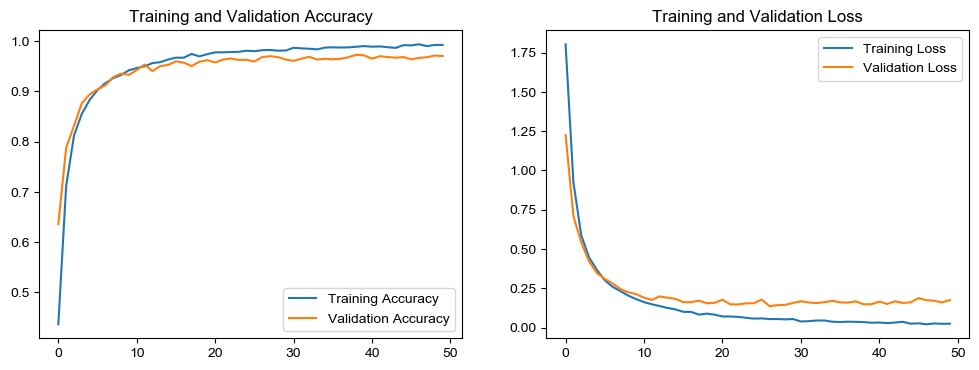

In [55]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


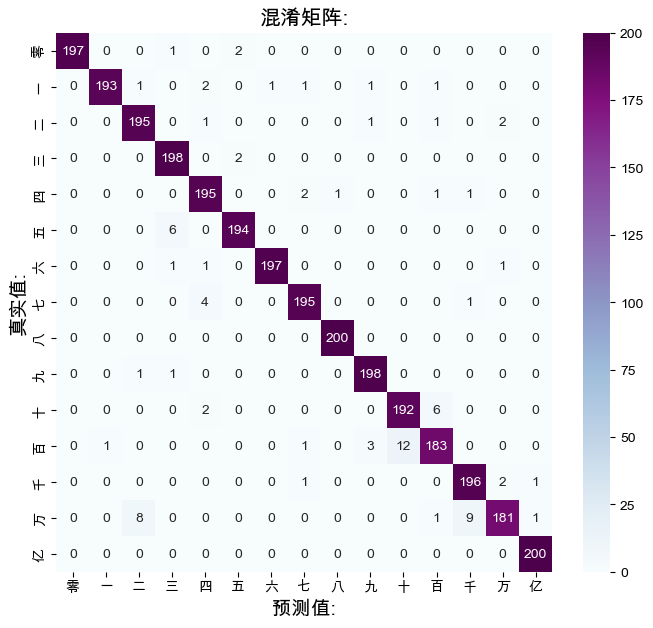

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

class_names = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '百', '千', '万', '亿']

def plot_cm(labels, predictions):
    conf_numpy = confusion_matrix(labels, predictions)
    conf_df = pd.DataFrame(conf_numpy, index=class_names, columns=class_names)

    plt.figure(figsize=(8, 7))

    sns.heatmap(conf_df, annot=True, fmt='d', cmap='BuPu')

    plt.title('混淆矩阵:', fontsize=15)
    plt.ylabel('真实值:', fontsize=14)
    plt.xlabel('预测值:', fontsize=14)

predicted = model.predict(X_test)
test_predicted = np.argmax(predicted, axis=1)
test_truth = np.argmax(y_test.values, axis=1)

plot_cm(test_truth, test_predicted)